In [2]:
import sys
import os
sys.path.insert(0, os.path.abspath('../..'))
from definitions import DB_PATH, PLATES_DIR
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import numpy as np
from src.db_retrieval.heatmapfromdatabase import normalize_yields, get_plot, plot_heatmap, plot_heatmap_overview

In [3]:
exp_nr = 'JG276'
exp_dir = PLATES_DIR / exp_nr
normalization_constant = 3.0
plate_size = 384

In [4]:
# this query selects all reactions that are the same as in JG228
# query = "SELECT well, product_A_lcms_ratio, product_B_lcms_ratio, product_C_lcms_ratio, product_D_lcms_ratio, product_E_lcms_ratio, product_F_lcms_ratio, product_G_lcms_ratio, product_H_lcms_ratio, vl_id  FROM experiments WHERE vl_id IN (SELECT vl_id FROM experiments WHERE lab_journal_number = ?) AND lab_journal_number != ?;"
# query_params = ('JG228', 'JG228')

In [6]:
# this query selects JG276
query = "SELECT well, product_A_lcms_ratio, product_B_lcms_ratio, product_C_lcms_ratio, product_D_lcms_ratio, product_E_lcms_ratio, product_F_lcms_ratio, product_G_lcms_ratio, product_H_lcms_ratio, vl_id FROM experiments WHERE lab_journal_number = ?;"
query_params = ('JG228',)

In [7]:
def read_yields(db_path, query, query_params):
    con = sqlite3.connect(db_path)
    cur = con.cursor()
    # TODO I need a possibility to produce heatmaps for arbitrary data, not just plates.
    #  Use cases:
    #   - Compare plate with a set of other syntheses that should be arranged in the same layout as the plate
    #   - Plot other formats than a plate (e.g. one monomer, all i, all t on the two axes)
    query_result = cur.execute(query, query_params).fetchall()
    con.close()
    df = pd.DataFrame(data=query_result,
                      columns=['well', 'product_A_lcms_ratio', 'product_B_lcms_ratio', 'product_C_lcms_ratio',
                               'product_D_lcms_ratio', 'product_E_lcms_ratio', 'product_F_lcms_ratio',
                               'product_G_lcms_ratio', 'product_H_lcms_ratio', 'vl_id'])
    df['row'] = df['well'].str[0]
    df['column'] = df['well'].str[1:]
    return df


def order_results(query_result, compare_plate):
    """
    Order the results of a query so that the heatmap overlays with the plate that we want to compare to.
    I.e. reaction 1 from compare_plate directs where the result of reaction 1 from query_result is going
    We use vl_id to match the reactions. Both inputs are DataFrames. We simply overwrite columns 'row' and 'column'
    in query_result df
    """
    query_result_new =  query_result.join(compare_plate, on='vl_id', rsuffix='_r')
    return query_result_new.drop(columns=['well_r', 'row', 'column', 'product_A_lcms_ratio_r', 'product_B_lcms_ratio_r', 'product_C_lcms_ratio_r',
                               'product_D_lcms_ratio_r', 'product_E_lcms_ratio_r', 'product_F_lcms_ratio_r',
                               'product_G_lcms_ratio_r', 'product_H_lcms_ratio_r'])






In [8]:
def read_yields_from_database(db_path, labjournal_nr):
    """
    Query DB for entries under one lab journal number and arrange the results in a dataframe.
    This is modified from the version in heatmapfromdatabase.py to accommodate queries that are not plate-wise
    """
    # PART 1: Query database to obtain a list of lists
    con = sqlite3.connect(db_path)
    cur = con.cursor()
    # TODO I need a possibility to produce heatmaps for arbitrary data, not just plates.
    #  Use cases:
    #   - Compare plate with a set of other syntheses that should be arranged in the same layout as the plate
    #   - Plot other formats than a plate (e.g. one monomer, all i, all t on the two axes)
    query_result = cur.execute('SELECT well, product_A_lcms_ratio, product_B_lcms_ratio, product_C_lcms_ratio, '
                               'product_D_lcms_ratio, product_E_lcms_ratio, product_F_lcms_ratio, product_G_lcms_ratio,'
                               'product_H_lcms_ratio, vl_id '
                               'FROM main.experiments '
                               'WHERE lab_journal_number = ?;',
                               (labjournal_nr,)
                               ).fetchall()
    con.close()
    # PART 2: Turn the list of lists into a dataframe. Split the 'well' into row and column
    df = pd.DataFrame(data=query_result,
                      columns=['well', 'product_A_lcms_ratio', 'product_B_lcms_ratio', 'product_C_lcms_ratio',
                               'product_D_lcms_ratio', 'product_E_lcms_ratio', 'product_F_lcms_ratio',
                               'product_G_lcms_ratio', 'product_H_lcms_ratio', 'vl_id'])
    df['row'] = df['well'].str[0]
    df['column'] = df['well'].str[1:]
    return df

In [9]:
plate = read_yields_from_database(DB_PATH, 'JG276')

In [10]:
plate

,well,product_A_lcms_ratio,product_B_lcms_ratio,product_C_lcms_ratio,product_D_lcms_ratio,product_E_lcms_ratio,product_F_lcms_ratio,product_G_lcms_ratio,product_H_lcms_ratio,vl_id,row,column
0,A1,0.007728,0.000000,0.000000,0.053056,0.017690,0.112190,0.031636,0.000000,9391,A,1
1,A10,0.047295,0.125941,0.062165,0.290244,0.088689,0.146604,0.002950,0.000000,76169,A,10
2,A11,0.026626,0.055438,0.000000,0.048495,0.107325,0.036397,0.002550,0.000000,9424,A,11
3,A12,0.019606,0.070850,0.032917,0.293614,0.075356,0.122162,0.003505,0.000000,76172,A,12
4,A13,0.077578,0.000000,0.002041,0.043481,0.000000,0.020263,0.022056,0.002969,9391,A,13
...,...,...,...,...,...,...,...,...,...,...,...,...
379,P5,0.080025,0.001766,0.000000,1.402898,0.834736,0.000000,0.000000,0.001448,16554,P,5
380,P6,0.075068,0.177828,0.000854,0.000000,0.017878,0.167442,0.002354,0.000000,16562,P,6
381,P7,0.357676,0.000000,0.000000,0.141016,0.304728,0.214084,0.051263,0.001946,43176,P,7
382,P8,0.373488,0.423599,0.000000,0.100609,0.680244,0.005058,0.002816,0.000775,43204,P,8


In [32]:
plate_reference = read_yields_from_database(DB_PATH, 'JG228')
compare_results = read_yields(DB_PATH, query, query_params)
# ordered_compare_results = order_results(compare_results, plate_reference)

In [33]:
for i, row in compare_results.iterrows():
    compare_results.at[i, 'row'] = plate_reference.loc[plate_reference['vl_id'] == row['vl_id'], ['row']].row.item()
    compare_results.at[i, 'column'] = plate_reference.loc[plate_reference['vl_id'] == row['vl_id'], ['column']].column.item()

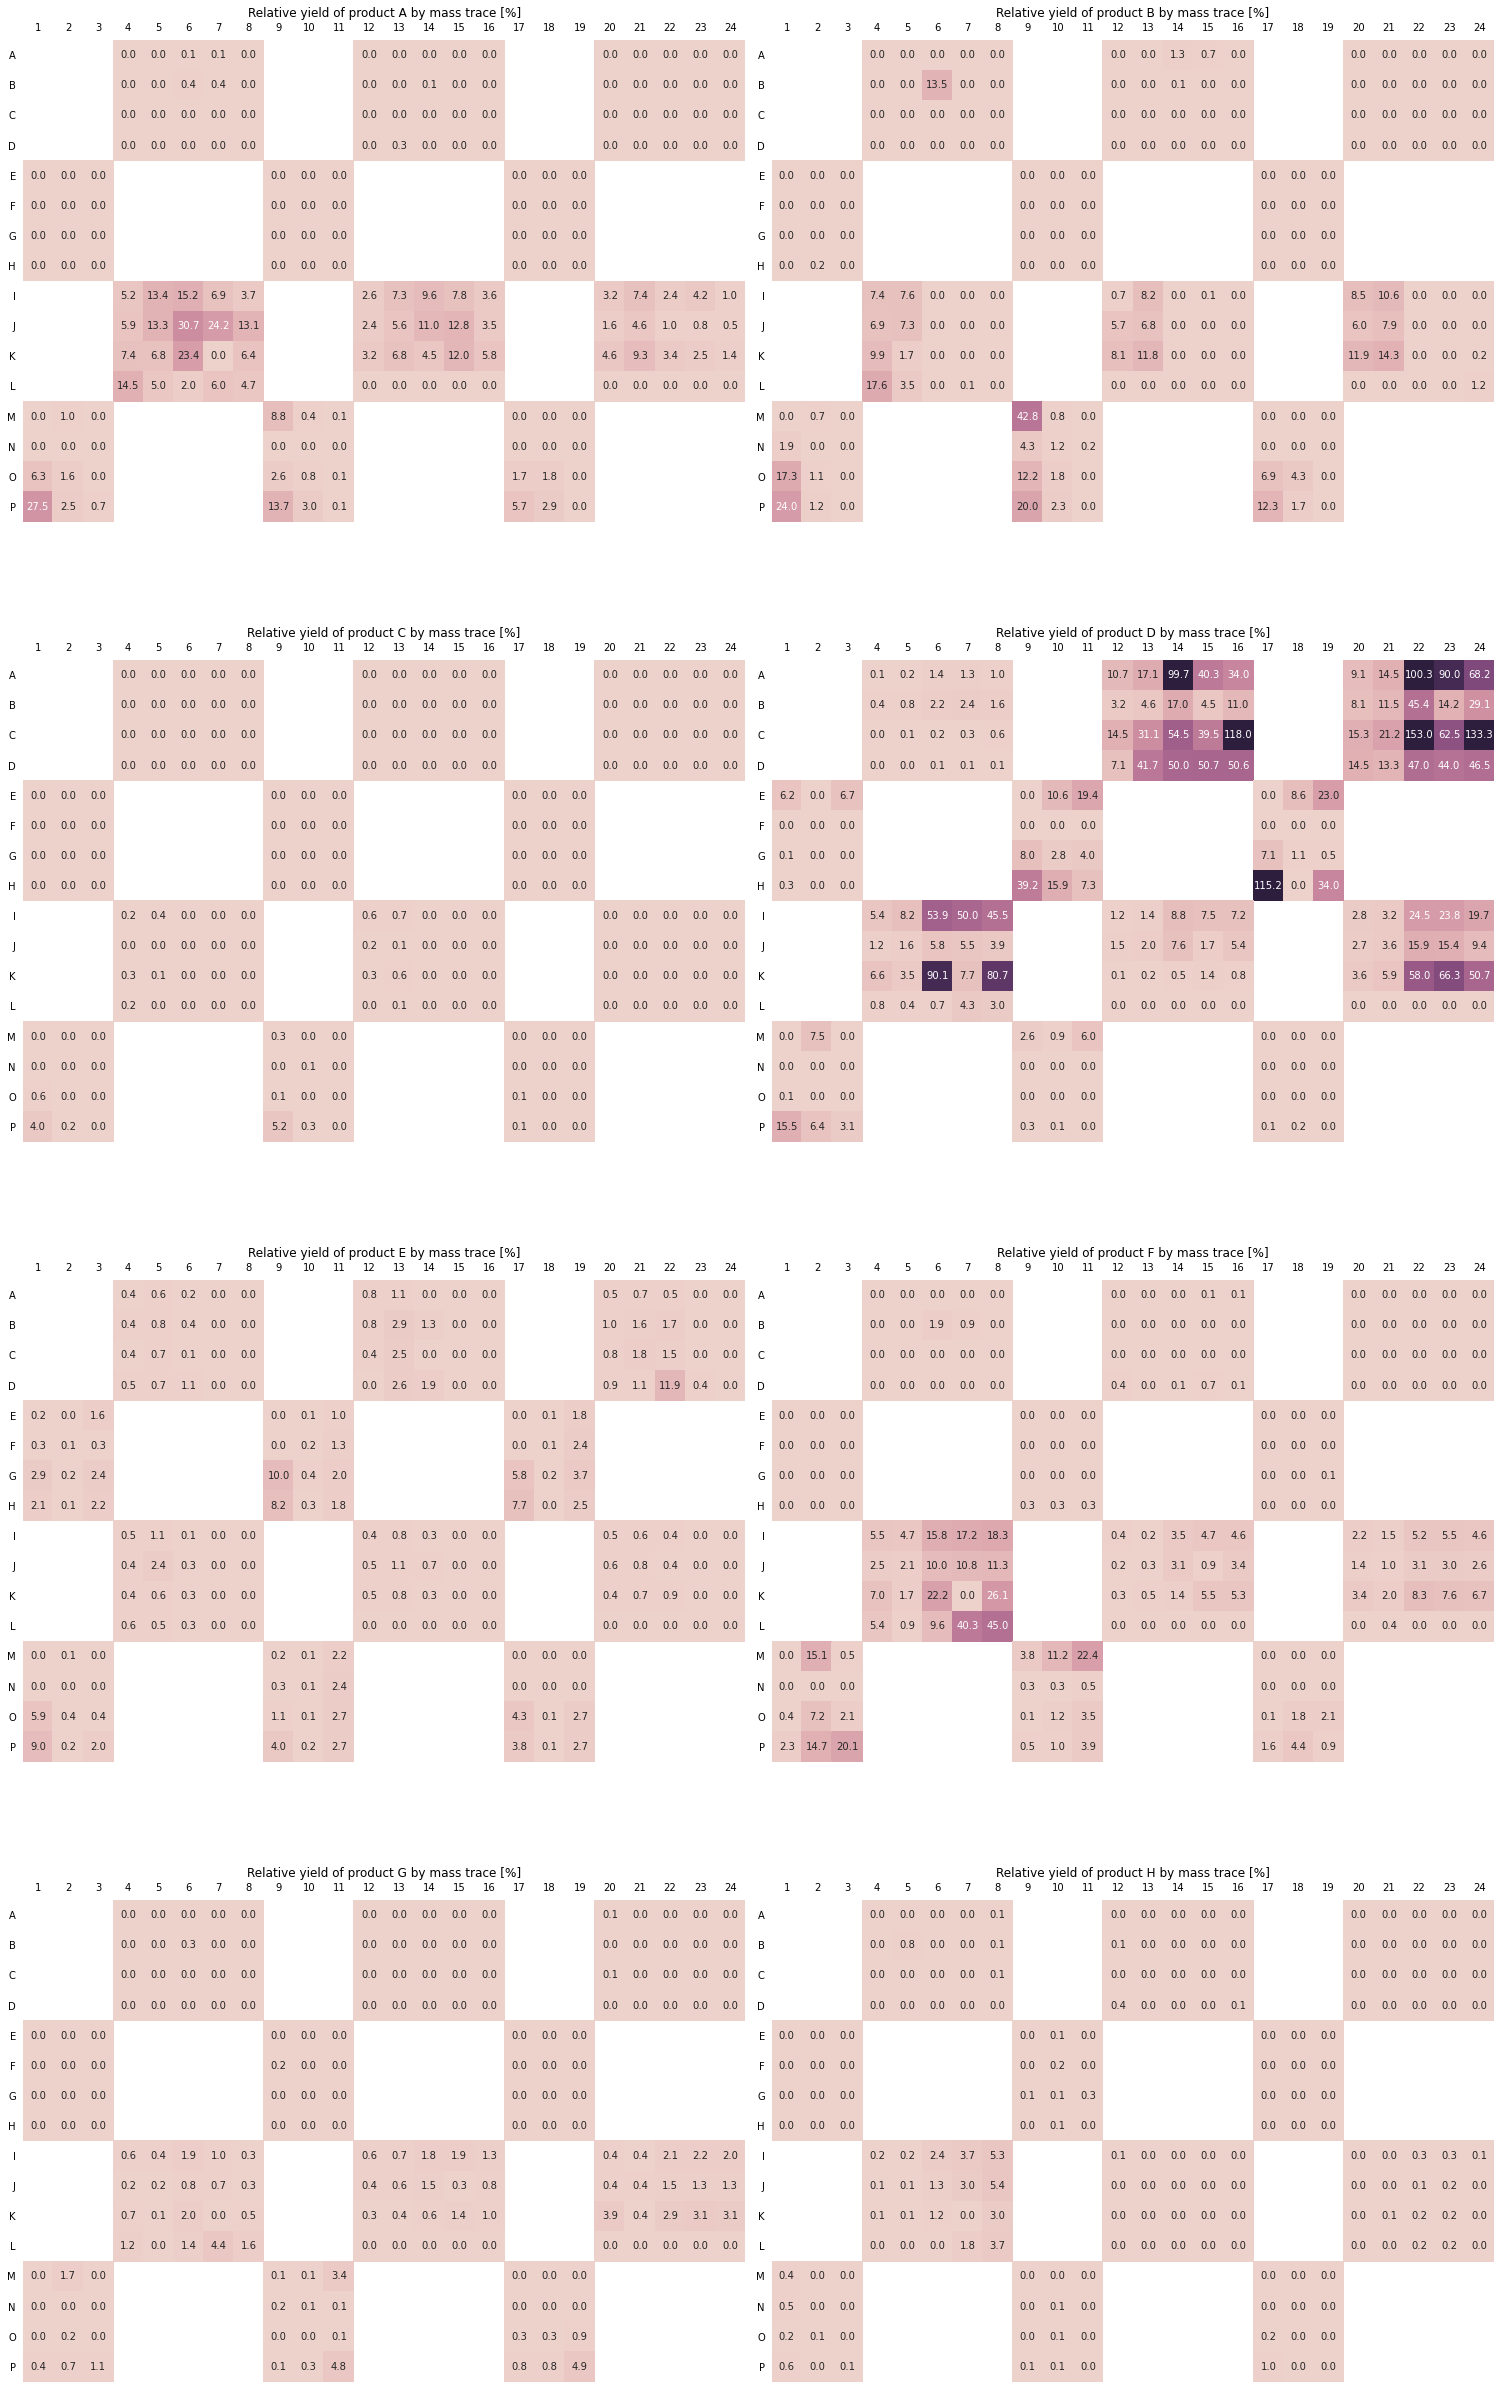

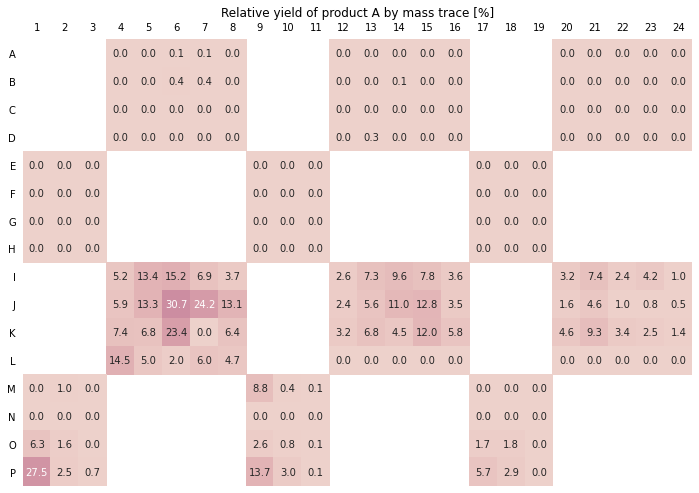

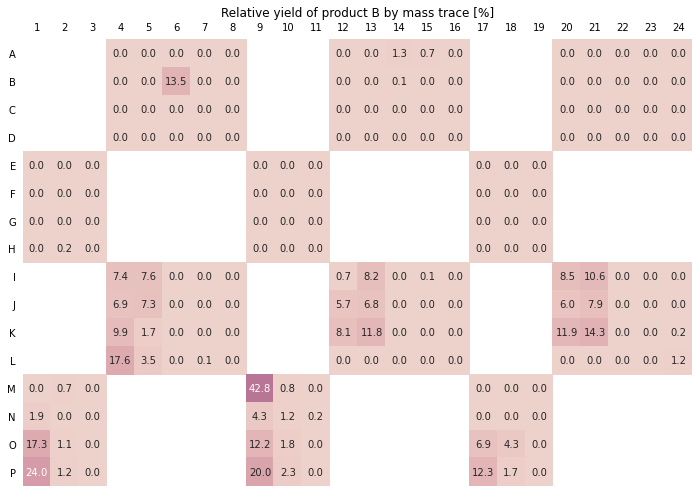

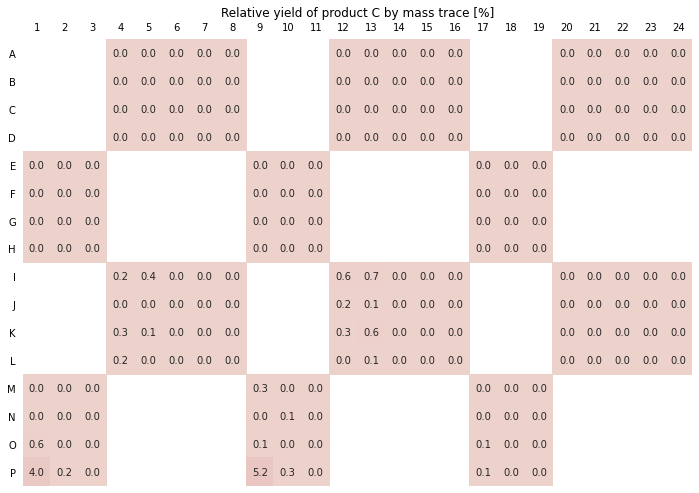

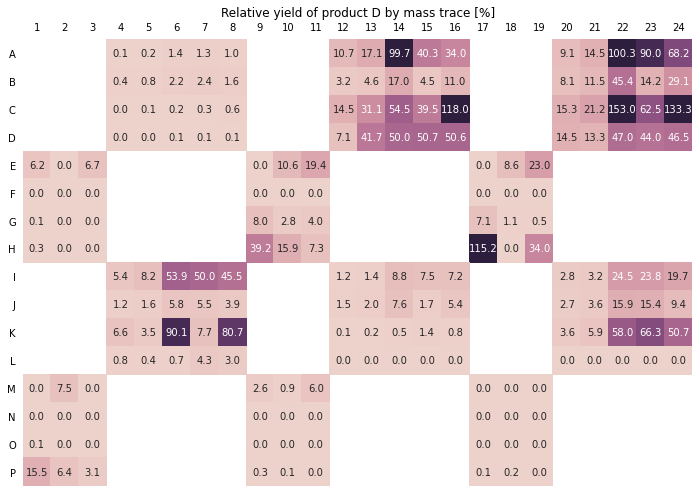

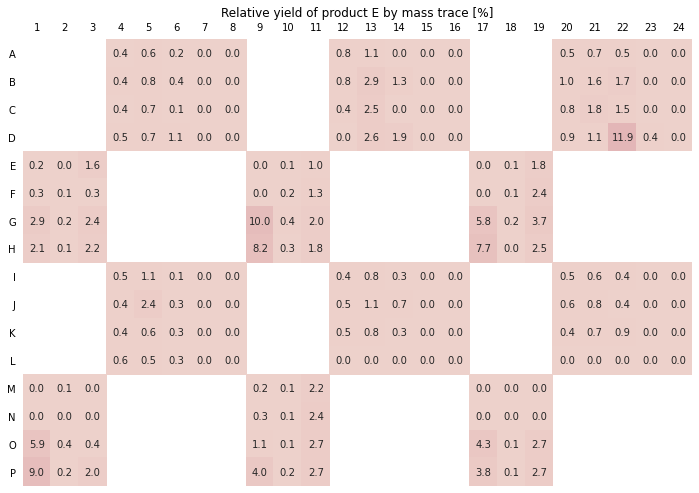

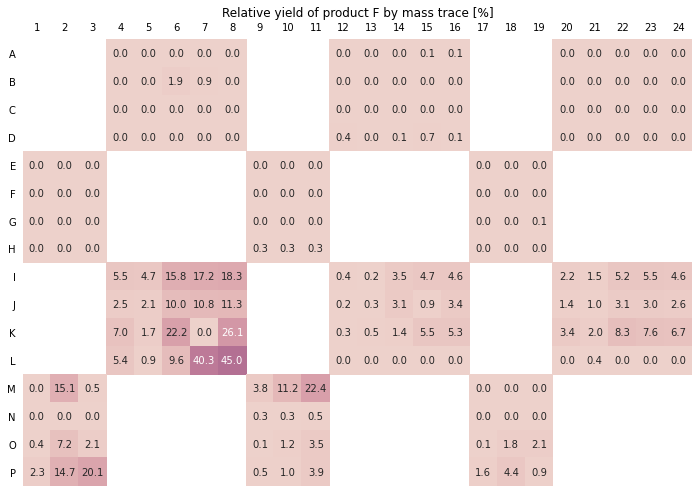

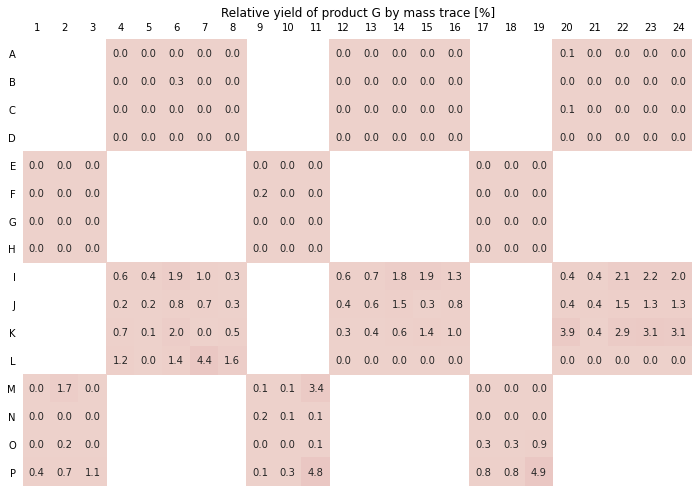

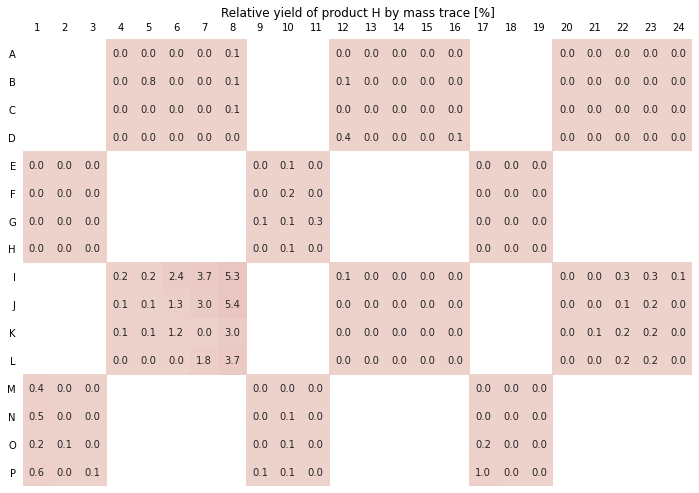

In [34]:
yields = normalize_yields(compare_results, normalization_constant)

# plot an overview with all individual heatmaps in a 4x2 grid
plot_heatmap_overview(yields, exp_dir / 'compare_reaction_overview.png')

# plot all heatmaps
for product_type in 'ABCDEFGH':
    df = yields[['row', 'column', f'product_{product_type}_lcms_ratio']]

    plot_df = df \
        .pivot(columns='column', index='row', values=f'product_{product_type}_lcms_ratio') \
        .sort_index(axis=1, key=lambda x: [int(y) for y in x])  # generate individual df for every plot
    # plot the heatmap
    plot_heatmap(plot_df, product_type, exp_dir / f'compare_reaction_{product_type}.png', plate_size)

In [20]:
plate['well'] = plate['well'].replace({'N14': 'O14', 
                                       'O14': 'N14',
                                       'N16': 'O16', 
                                       'O16': 'N16',
                                       'N18': 'O18', 
                                       'O18': 'N18',
                                       'N20': 'O20', 
                                       'O20': 'N20',
                                       'N22': 'O22', 
                                       'O22': 'N22',
                                       'N24': 'O24', 
                                       'O24': 'N24',
                                      })

300    M20
301    M21
302    M22
303    M23
304    M24
305     M3
306     M4
307     M5
308     M6
309     M7
310     M8
311     M9
312     N1
313    N10
314    N11
315    N12
316    N13
317    O14
318    N15
319    N16
320    N17
321    N18
322    N19
323     N2
324    N20
325    N21
326    N22
327    N23
328    N24
329     N3
330     N4
331     N5
332     N6
333     N7
334     N8
335     N9
336     O1
337    O10
338    O11
339    O12
340    O13
341    N14
342    O15
343    O16
344    O17
345    O18
346    O19
347     O2
348    O20
349    O21
350    O22
351    O23
352    O24
353     O3
354     O4
355     O5
356     O6
357     O7
358     O8
359     O9
Name: well, dtype: object